<a href="https://colab.research.google.com/github/AlessiaDG/Algorithms-for-massive-data/blob/main/Plant_leave_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Algorithms for Massive Data - Plant leave recognizer
Di Giovanni Alessia

Libraries


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import shutil
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from google.colab import output
import io, base64
import random
from PIL import Image

In [2]:
!pip install keras-tuner --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.2 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt

Load the dataset from Kaggle




In [4]:
os.environ['KAGGLE_USERNAME'] = 	"XXXX"
os.environ['KAGGLE_KEY'] = "XXXX"
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification --unzip

100% 6.55G/6.56G [01:20<00:00, 108MB/s] 
100% 6.56G/6.56G [01:20<00:00, 87.1MB/s]


Delete diseased leaves

In [5]:
#Paths for train, validation and test directories
train_path = '/content/Plants_2/train'
val_path = '/content/Plants_2/valid'
test_path = '/content/Plants_2/test'

In [6]:
#Classes names and number of classes in train
subfolders = [f.name for f in os.scandir(train_path) if f.is_dir()]
print(subfolders)
print(len(subfolders))

['Jamun diseased (P5b)', 'Jatropha diseased (P6b)', 'Lemon diseased (P10b)', 'Basil healthy (P8)', 'Pomegranate diseased (P9b)', 'Pongamia Pinnata diseased (P7b)', 'Chinar diseased (P11b)', 'Gauva diseased (P3b)', 'Pongamia Pinnata healthy (P7a)', 'Bael diseased (P4b)', 'Pomegranate healthy (P9a)', 'Mango healthy (P0a)', 'Alstonia Scholaris diseased (P2a)', 'Jamun healthy (P5a)', 'Mango diseased (P0b)', 'Lemon healthy (P10a)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Gauva healthy (P3a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)', 'Arjun diseased (P1a)']
22


In [7]:
#Function to delete subfolders with a specific keyword
def delete_subfolders_with_keyword(directory_path, keyword_to_delete):
      subfolders = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]
      for subfolder in subfolders:
        if keyword_to_delete in subfolder:
            subfolder_path = os.path.join(directory_path, subfolder)
            shutil.rmtree(subfolder_path)

keyword_to_delete = "diseased"

delete_subfolders_with_keyword(train_path, keyword_to_delete)
delete_subfolders_with_keyword(val_path, keyword_to_delete)
delete_subfolders_with_keyword(test_path, keyword_to_delete)

print("Deletion complete.")

Deletion complete.


In [8]:
#Classes names and number of classes in train after deletion
subfolders = [f.name for f in os.scandir(train_path) if f.is_dir()]
print(subfolders)
print(len(subfolders))

['Basil healthy (P8)', 'Pongamia Pinnata healthy (P7a)', 'Pomegranate healthy (P9a)', 'Mango healthy (P0a)', 'Jamun healthy (P5a)', 'Lemon healthy (P10a)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Gauva healthy (P3a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)']
11


Preprocessing: resize images and data augmentation

In [9]:
root_directory = '/content/Plants_2'

def is_rgb_image(image_path):
    try:
        img = Image.open(image_path)
        return img.mode == 'RGB'
    except Exception as e:
        return False

all_images_are_rgb = True

for filename in os.listdir(root_directory):
    if filename.endswith(('.jpg')):
        image_path = os.path.join(directory, filename)
        is_rgb = is_rgb_image(image_path)
        if not is_rgb:
            all_images_are_rgb = False
            break
if all_images_are_rgb:
    print("All images in the directory are in RGB color format.")
else:
    print("Not all images in the directory are in RGB color format.")

All images in the directory are in RGB color format.


In [10]:
#Function to know the size of one image
example_image_path = '/content/Plants_2/train/Alstonia Scholaris healthy (P2b)/0003_0011.JPG'

with Image.open(example_image_path) as img:
    width, height = img.size

print(f"Image size: {width}x{height}")

Image size: 6000x4000


In [11]:
root_directory = '/content/Plants_2'


first_image_width = None
first_image_height = None

same_dimensions = True

for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_path = os.path.join(root, file)

            with Image.open(image_path) as img:
                width, height = img.size

            if first_image_width is None and first_image_height is None:
                first_image_width = width
                first_image_height = height
            else:
                if width != first_image_width or height != first_image_height:
                    same_dimensions = False
                    break  #Stop checking if dimensions don't match

print(f"All images have the same dimensions: {same_dimensions}")

All images have the same dimensions: True


In [12]:
#Subfolder names in each directory
train_subfolders = [f.name for f in os.scandir(train_path) if f.is_dir()]
val_subfolders = [f.name for f in os.scandir(val_path) if f.is_dir()]
test_subfolders = [f.name for f in os.scandir(test_path) if f.is_dir()]

print("Subfolders in the train directory:", train_subfolders)
print("Subfolders in the validation directory:", val_subfolders)
print("Subfolders in the test directory:", test_subfolders)

#Dictionary for counts
element_counts = {}

#Number of elements in each subfolder for train, validation and test
for subfolder in train_subfolders:
    subfolder_path = os.path.join(train_path, subfolder)
    num_elements = len(os.listdir(subfolder_path))
    element_counts[f"Train/{subfolder}"] = num_elements

for subfolder in val_subfolders:
    subfolder_path = os.path.join(val_path, subfolder)
    num_elements = len(os.listdir(subfolder_path))
    element_counts[f"Validation/{subfolder}"] = num_elements

for subfolder in test_subfolders:
    subfolder_path = os.path.join(test_path, subfolder)
    num_elements = len(os.listdir(subfolder_path))
    element_counts[f"Test/{subfolder}"] = num_elements

for folder, count in element_counts.items():
    print(f"Folder: {folder}, Number of Elements: {count}")

Subfolders in the train directory: ['Basil healthy (P8)', 'Pongamia Pinnata healthy (P7a)', 'Pomegranate healthy (P9a)', 'Mango healthy (P0a)', 'Jamun healthy (P5a)', 'Lemon healthy (P10a)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Gauva healthy (P3a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)']
Subfolders in the validation directory: ['Basil healthy (P8)', 'Pongamia Pinnata healthy (P7a)', 'Pomegranate healthy (P9a)', 'Mango healthy (P0a)', 'Jamun healthy (P5a)', 'Lemon healthy (P10a)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Gauva healthy (P3a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)']
Subfolders in the test directory: ['Basil healthy (P8)', 'Pongamia Pinnata healthy (P7a)', 'Pomegranate healthy (P9a)', 'Mango healthy (P0a)', 'Jamun healthy (P5a)', 'Lemon healthy (P10a)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Gauva healthy (P3a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)']
Folder: Train/Basil heal

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=90, zoom_range=0.2, vertical_flip=True, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255) #Apply only scaling for test images

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),#Every image will be resized to this size
    color_mode="rgb",
    batch_size= 32,
    class_mode="categorical",
    shuffle=True,
    seed=123 #Random seed for applying random image augmentation and shuffling the order of the image
)

valid_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size= 32,
    class_mode="categorical",
    shuffle=True,
    seed=123
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size= 32,
    class_mode="categorical",
    shuffle=False, #Set this to False, because I need to yield the images in “order”, to predict the outputs and match them with their unique filenames
    seed=123
)

Found 2163 images belonging to 11 classes.
Found 55 images belonging to 11 classes.
Found 55 images belonging to 11 classes.


Model construction and hyperparameter tuning


In [20]:
def CNN_model(hp):
  model = tf.keras.Sequential()
  hp_filters= hp.Choice('filters', values =[16, 32, 64])
  hp_dense_units = hp.Choice('dense_units', values=[128, 256])
  hp_dropout_rate = hp.Float('dropout_rates', min_value=0.2, max_value = 0.5, step = 0.1)

  model.add(tf.keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), input_shape=(256, 256, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(hp_dropout_rate))

  model.add(tf.keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(hp_dropout_rate))

  model.add(tf.keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(hp_dropout_rate))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(hp_dense_units, activation='relu'))
  model.add(tf.keras.layers.Dropout(hp_dropout_rate))

  model.add(tf.keras.layers.Dense(11, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
  return model

In [21]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [22]:
tuner_search=RandomSearch(CNN_model, objective='val_accuracy', max_trials=3, directory='output', project_name='leaves')

In [23]:
tuner_search.search(train_generator, validation_data = valid_generator, epochs=3)

Trial 3 Complete [00h 25m 19s]
val_accuracy: 0.38181817531585693

Best val_accuracy So Far: 0.4000000059604645
Total elapsed time: 01h 14m 38s


In [24]:
best_hyperparameters = tuner_search.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'filters': 32, 'dense_units': 128, 'dropout_rates': 0.30000000000000004}

In [25]:
my_model = tuner_search.hypermodel.build(best_hyperparameters)
#Train the model on the training set for 20 epochs but stop it if val_loss isn't better
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, start_from_epoch=10)]
history = my_model.fit(train_generator, epochs=20, validation_data = valid_generator, callbacks = stop_early)

Epoch 1/20
68/68 [==============================] - 522s 8s/step - loss: 2.3633 - accuracy: 0.1308 - val_loss: 2.3078 - val_accuracy: 0.2182
Epoch 2/20
68/68 [==============================] - 485s 7s/step - loss: 1.9677 - accuracy: 0.3135 - val_loss: 1.8208 - val_accuracy: 0.4182
Epoch 3/20
68/68 [==============================] - 494s 7s/step - loss: 1.6043 - accuracy: 0.4369 - val_loss: 1.4730 - val_accuracy: 0.5091
Epoch 4/20
68/68 [==============================] - 515s 8s/step - loss: 1.3818 - accuracy: 0.5372 - val_loss: 1.3536 - val_accuracy: 0.4909
Epoch 5/20
68/68 [==============================] - 482s 7s/step - loss: 1.2451 - accuracy: 0.5774 - val_loss: 1.0662 - val_accuracy: 0.7273
Epoch 6/20
68/68 [==============================] - 508s 7s/step - loss: 1.1308 - accuracy: 0.6190 - val_loss: 1.0898 - val_accuracy: 0.6545
Epoch 7/20
68/68 [==============================] - 478s 7s/step - loss: 1.0193 - accuracy: 0.6708 - val_loss: 1.1036 - val_accuracy: 0.5818
Epoch 8/20
68

In [26]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)       

Text(0.5, 1.0, 'Training vs Validation Accuracy')

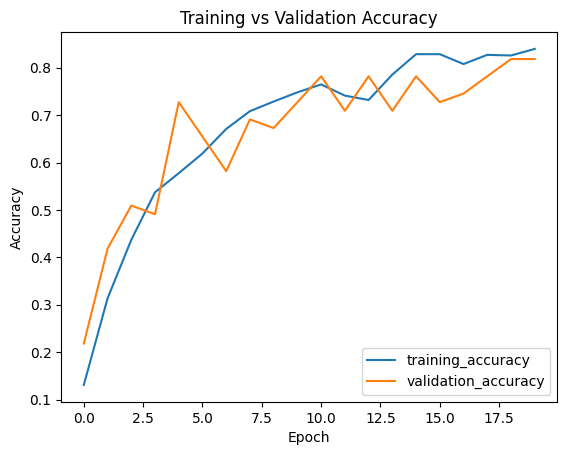

In [27]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation Accuracy")

Text(0.5, 1.0, 'Training vs Validation Loss')

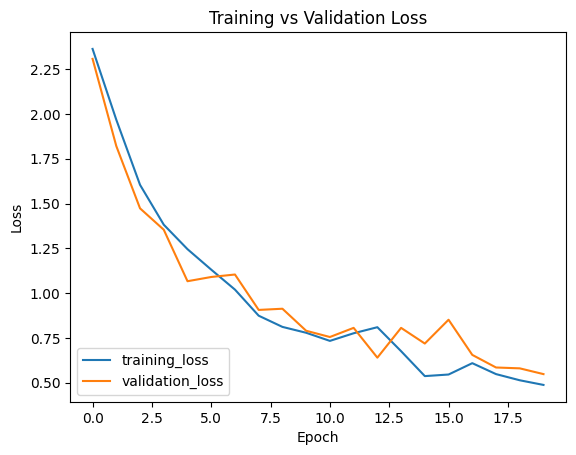

In [28]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.title("Training vs Validation Loss")

In [29]:
test_loss, test_acc = my_model.evaluate(test_generator)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

2/2 [==============================] - 9s 3s/step - loss: 0.2704 - accuracy: 0.8909
Test Loss: 0.2703778147697449
Test Accuracy: 0.8909090757369995


Make predictions

In [30]:
predictions = my_model.predict(test_generator)

2/2 [==============================] - 9s 3s/step


In [31]:
predicted_labels = np.argmax(predictions, axis=1)

In [32]:
predicted_labels

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  3,  6,
        5,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  7,  9,  0,  9,  9, 10,
       10, 10, 10, 10])

In [33]:
true_labels = test_generator.labels

In [34]:
true_labels

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10], dtype=int32)

In [35]:
labels = test_generator.class_indices
labels = {v: k for k, v in labels.items()}
labels

{0: 'Alstonia Scholaris healthy (P2b)',
 1: 'Arjun healthy (P1b)',
 2: 'Basil healthy (P8)',
 3: 'Chinar healthy (P11a)',
 4: 'Gauva healthy (P3a)',
 5: 'Jamun healthy (P5a)',
 6: 'Jatropha healthy (P6a)',
 7: 'Lemon healthy (P10a)',
 8: 'Mango healthy (P0a)',
 9: 'Pomegranate healthy (P9a)',
 10: 'Pongamia Pinnata healthy (P7a)'}

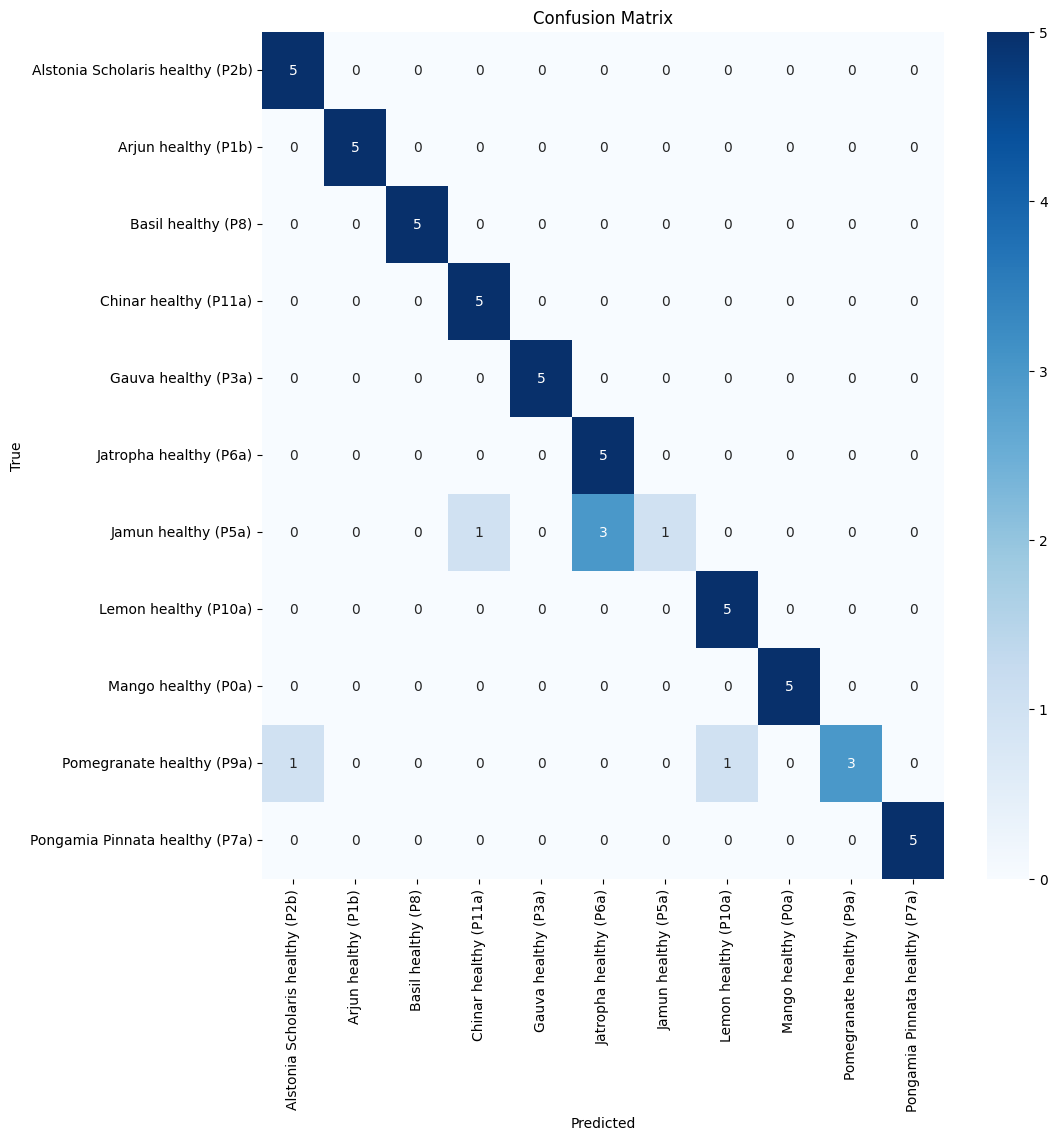

In [36]:
true_labels = test_generator.classes

class_names = ['Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)', 'Basil healthy (P8)', 'Chinar healthy (P11a)', 'Gauva healthy (P3a)', 'Jatropha healthy (P6a)', 'Jamun healthy (P5a)', 'Lemon healthy (P10a)', 'Mango healthy (P0a)', 'Pomegranate healthy (P9a)', 'Pongamia Pinnata healthy (P7a)']

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()